In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier



In [2]:
df = pd.read_csv('/content/Preprocessed_DataSet.csv')
df.head()

,Title,text
0,Administrative Assistant,responsible managing administration including...
1,Lawyer,drawing juridical document drawing contr verif...
2,Accountant,manage program financial budget organization ...
3,Administrative Assistant,translation interpretation service profession...
4,Project Manager,daily management project leading supervising ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   1222 non-null   object
 1   text    1222 non-null   object
dtypes: object(2)
memory usage: 19.2+ KB


In [6]:
df.describe()

,Title,text
count,1222,1222
unique,7,1128
top,Accountant,visit medical institution entity meet doctor p...
freq,292,6


In [7]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Tokenization and preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [word.lower() for word in tokens]

    # Removing punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply preprocessing to the 'text' column
df['text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df.head(n=3)

,Title,text
0,Administrative Assistant,respons manag administr includ account adminis...
1,Lawyer,draw jurid document draw contr verifi contr ef...
2,Accountant,manag program financi budget organ implement g...


## Logistic Regression

In [10]:
# Prepare the data
X = df['text']
y = df['Title']

# Encode the target variable using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define preprocessing steps
tfidf_vectorizer = TfidfVectorizer()

# Building a pipeline
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', LogisticRegression(max_iter=200))
])

# Define hyperparameters
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10],       # Regularization parameter
    'clf__solver': ['liblinear', 'saga']

}


In [11]:
# Performing hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y_encoded)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=200))]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__solver': ['liblinear', 'saga'],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [12]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'clf__C': 10, 'clf__solver': 'liblinear', 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}


In [13]:
# Train the model
best_model = grid_search.best_estimator_
LR_X_train, LR_X_test, LR_y_train, LR_y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)
best_model.fit(LR_X_train, LR_y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=3000)),
                ('clf',
                 LogisticRegression(C=10, max_iter=200, solver='liblinear'))])

In [15]:
# Evaluate the model
# Predictions
LR_y_train_pred = best_model.predict(LR_X_train)
LR_y_test_pred = best_model.predict(LR_X_test)

# Error metrics
LR_r2_train = r2_score(LR_y_train, LR_y_train_pred)
LR_mse_train = mean_squared_error(LR_y_train, LR_y_train_pred)
LR_mae_train = mean_absolute_error(LR_y_train, LR_y_train_pred)

LR_r2_test = r2_score(LR_y_test, LR_y_test_pred)
LR_mse_test = mean_squared_error(LR_y_test, LR_y_test_pred)
LR_mae_test = mean_absolute_error(LR_y_test, LR_y_test_pred)

In [16]:
print("Training R-squared:", LR_r2_train)
print("Training MSE:", LR_mse_train)
print("Training MAE:", LR_mae_train)

print("Testing R-squared:", LR_r2_test)
print("Testing MSE:", LR_mse_test)
print("Testing MAE:", LR_mae_test)

Training R-squared: 0.9941646587564711
Training MSE: 0.02456499488229273
Training MAE: 0.012282497441146366
Testing R-squared: 0.8359073359073359
Testing MSE: 0.6938775510204082
Testing MAE: 0.2530612244897959


In [17]:
# Calculate accuracy
accuracy = accuracy_score(LR_y_test, LR_y_test_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
class_metrics = classification_report(LR_y_test, LR_y_test_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_metrics)


Accuracy: 0.8938775510204081
Classification Report:
                          precision    recall  f1-score   support

              Accountant       0.78      0.85      0.81        59
Administrative Assistant       0.94      1.00      0.97        29
        Chief Accountant       0.77      0.68      0.72        40
                  Lawyer       1.00      1.00      1.00        29
  Medical Representative       1.00      0.97      0.99        36
         Project Manager       0.95      0.86      0.90        22
           Sales Manager       0.97      1.00      0.98        30

                accuracy                           0.89       245
               macro avg       0.92      0.91      0.91       245
            weighted avg       0.89      0.89      0.89       245



## Decision Tree

In [19]:
# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
])

# Define hyperparameters for tuning
parameters = {
    'tfidf__max_features': [1000],
    'clf__max_depth': [10],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [1, 2]
}

# Split data into training and testing sets
DT_X_train, DT_X_test, DT_y_train, DT_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Performing hyperparameter tuning using GridSearchCV
DT = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
DT.fit(DT_X_train, DT_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [10],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [2],
                         'tfidf__max_features': [1000]})

Run time : 11 seconds

In [21]:
# Best parameters
print("Best parameters found by GridSearchCV:")
print(DT.best_params_)


Best parameters found by GridSearchCV:
{'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'tfidf__max_features': 1000}


In [22]:
# Evaluate the model
# Training set
DT_y_train_pred = DT.predict(DT_X_train)
DT_y_test_pred = DT.predict(DT_X_test)


In [23]:
# Calculate accuracy metrics and classification report
DT_accuracy = accuracy_score(DT_y_test, DT_y_test_pred)
DT_precision = precision_score(DT_y_test, DT_y_test_pred, average='weighted')
DT_recall = recall_score(DT_y_test, DT_y_test_pred, average='weighted')

print("Accuracy:", DT_accuracy)
print("Precision:", DT_precision)
print("Recall:", DT_recall)
print("Classification Report:")
print(classification_report(DT_y_test, DT_y_test_pred))

Accuracy: 0.8530612244897959
Precision: 0.8550651777939795
Recall: 0.8530612244897959
Classification Report:
                          precision    recall  f1-score   support

              Accountant       0.86      0.87      0.86        68
Administrative Assistant       0.81      0.59      0.68        22
        Chief Accountant       0.77      0.71      0.74        38
                  Lawyer       0.94      1.00      0.97        29
  Medical Representative       0.94      0.97      0.96        33
         Project Manager       0.95      0.84      0.89        25
           Sales Manager       0.74      0.93      0.82        30

                accuracy                           0.85       245
               macro avg       0.86      0.84      0.85       245
            weighted avg       0.86      0.85      0.85       245



## Random Forest

In [24]:
# Split the data into training and testing sets
X = df['text']
y = df['Title']
RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline and define parameter grid for hyperparameter tuning
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'clf__n_estimators': [100, 200],
}

In [25]:
# Use GridSearchCV for hyperparameter tuning
RF = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
RF.fit(RF_X_train, RF_y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_estimators': [100, 200],
                         'tfidf__max_features': [1000, 2000, 3000]})

# Run time: 35 seconds

In [26]:
# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__C': 10, 'clf__solver': 'liblinear', 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}


In [27]:
# Fit the pipeline to the training data
best_pipeline = RF.best_estimator_
best_pipeline.fit(RF_X_train, RF_y_train)

# Evaluate the model on the testing data
RF_y_pred = best_pipeline.predict(RF_X_test)

In [28]:
# Calculate accuracy metrics and classification report
RF_accuracy = accuracy_score(RF_y_test, RF_y_pred)
RF_precision = precision_score(RF_y_test, RF_y_pred, average='weighted')
RF_recall = recall_score(RF_y_test, RF_y_pred, average='weighted')

print("Accuracy:", RF_accuracy)
print("Precision:", RF_precision)
print("Recall:", RF_recall)
print("Classification Report:")
print(classification_report(RF_y_test, RF_y_pred))

Accuracy: 0.9183673469387755
Precision: 0.9229779334093886
Recall: 0.9183673469387755
Classification Report:
                          precision    recall  f1-score   support

              Accountant       0.81      0.95      0.87        59
Administrative Assistant       0.91      1.00      0.95        29
        Chief Accountant       0.90      0.68      0.77        40
                  Lawyer       0.96      0.93      0.95        29
  Medical Representative       1.00      1.00      1.00        36
         Project Manager       1.00      0.91      0.95        22
           Sales Manager       1.00      1.00      1.00        30

                accuracy                           0.92       245
               macro avg       0.94      0.92      0.93       245
            weighted avg       0.92      0.92      0.92       245



## User interface output

In [29]:
# Running the model to a new data set to predict suitable Title
text = "Reporting to the chief accountant of the company Generating General Cashier reports Preparing quarterly accounting reports for the company Over three years of experience in accounting Familiarity with international accounting standards Understanding of non-resident company operations Experience in the communication sphere optional Previous involvement with non-resident companies"
text = preprocess_text(text)

print(text)


report chief account compani gener gener cashier report prepar quarterli account report compani three year experi account familiar intern account standard understand non-resid compani oper experi commun sphere option previou involv non-resid compani


In [30]:
predicted_title = best_pipeline.predict([text])
print(predicted_title)

['Accountant']


## Naive Bayes

In [31]:
X = df['text']
y = df['Title']

# Creating a TfidfVectorizer instance
vectorizer = TfidfVectorizer()

# Transforming the text data into TF-IDF matrix
X_tfidf = vectorizer.fit_transform(X)

# Converting sparse matrix to dense matrix
X_tfidf_dense = X_tfidf.toarray()

# Display the TF-IDF values
print("TF-IDF Values:")
print(X_tfidf_dense)


TF-IDF Values:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
unique_values = np.unique(X_tfidf_dense)
print(unique_values)

[0.         0.00738279 0.00744241 ... 0.73784549 0.75216114 0.75567916]


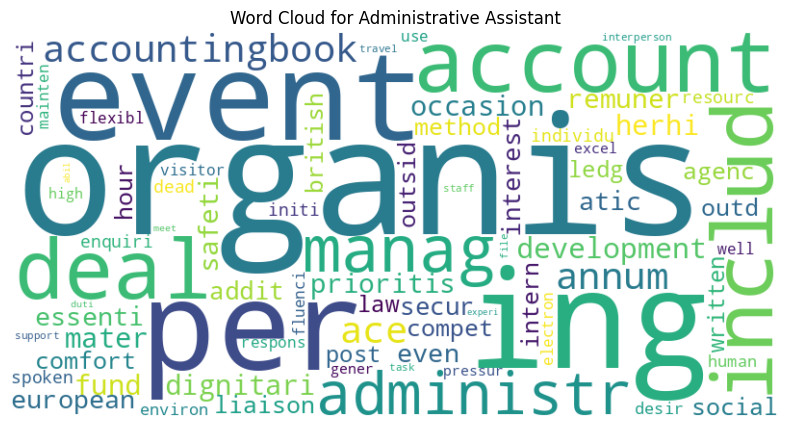

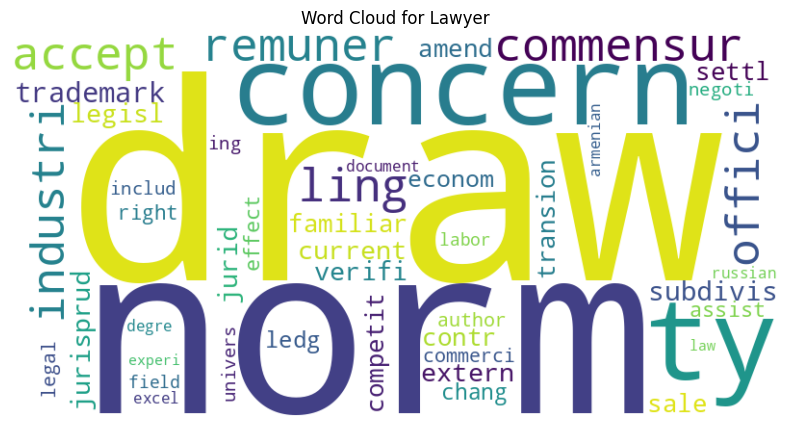

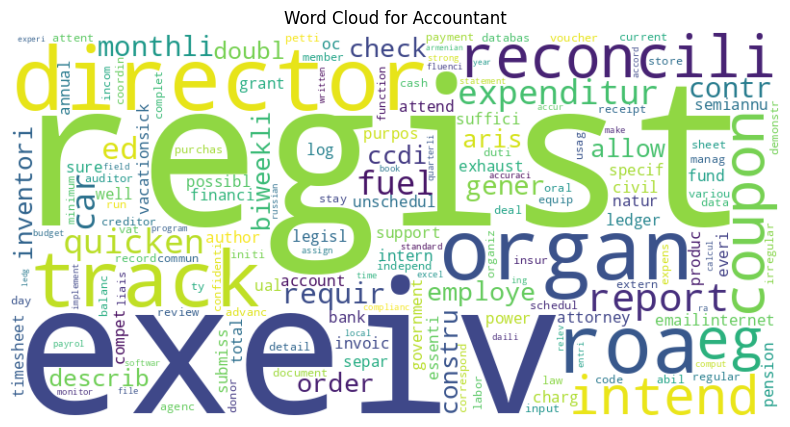

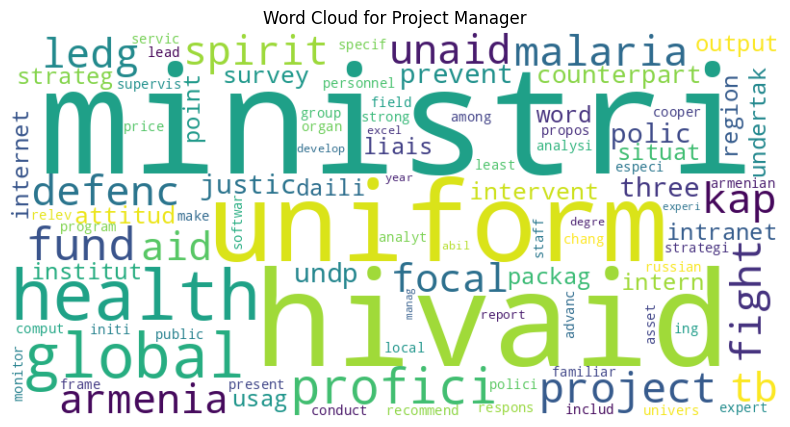

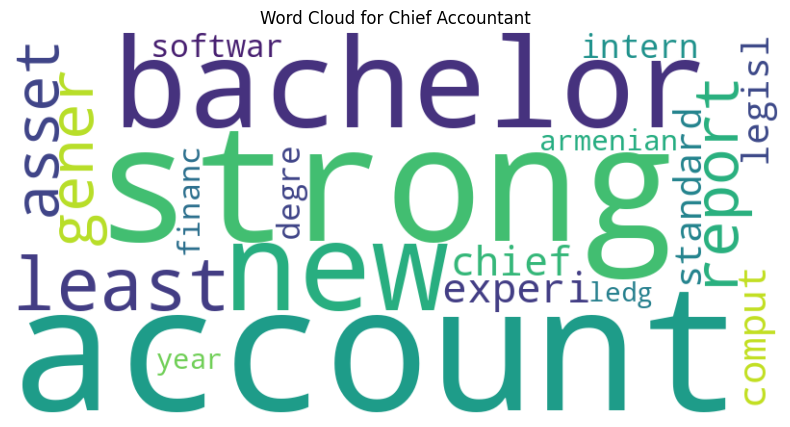

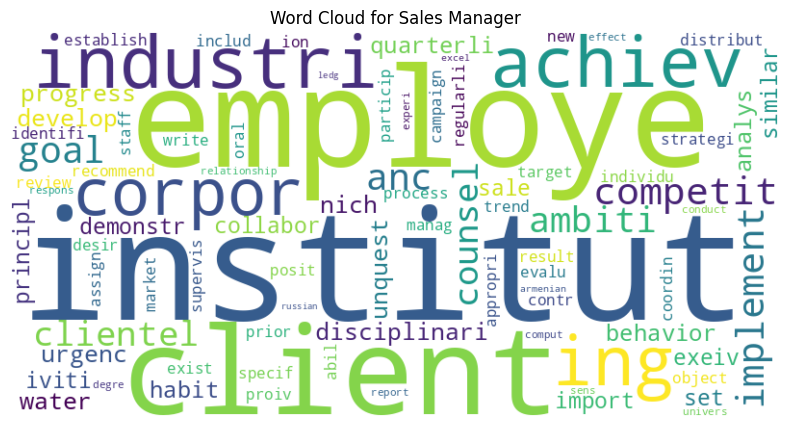

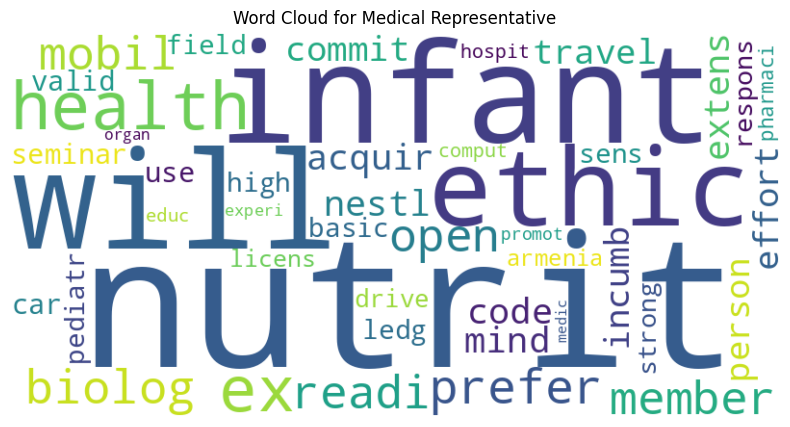

In [34]:
# Iterate over each category
for category in df['Title'].unique():
    # Filter text data for the current category
    text_category = df[df['Title'] == category]['text']

    # Create a TfidfVectorizer instance
    vectorizer = TfidfVectorizer()

    # Transform the text data into TF-IDF matrix
    X_tfidf_category = vectorizer.fit_transform(text_category)

    # Get feature names from TfidfVectorizer's vocabulary
    feature_names = vectorizer.get_feature_names_out()

    # Create a dictionary mapping feature names to TF-IDF values
    tfidf_dict = {feature_names[i]: X_tfidf_category[0, i] for i in range(X_tfidf_category.shape[1])}

    # Initialize WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white')

    # Fit the WordCloud object with TF-IDF values
    wordcloud.fit_words(tfidf_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {category}")
    plt.axis('off')
    plt.show()


In [35]:
# Splitting the dataset into training and test sets
NB_X_train, NB_X_test, NB_y_train, NB_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with TF-IDF vectorizer and Naive Bayes classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define hyperparameters to tune
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 2),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'nb__alpha': (0.1, 0.5, 1.0),
}


In [36]:
# Perform grid search cross-validation
NB = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
NB.fit(NB_X_train, NB_y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': (0.1, 0.5, 1.0),
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__min_df': (1, 2),
                         'tfidf__ngram_range': ((1, 1), (1, 2))},
             verbose=1)

Run time : 30 secods

In [37]:
# Best parameters found
print("Best parameters found:")
print(NB.best_params_)

Best parameters found:
{'nb__alpha': 0.1, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [38]:
# Evaluate the model on test set
NB_y_pred = NB.predict(NB_X_test)

# Calculate accuracy metrics
NB_accuracy = accuracy_score(NB_y_test, NB_y_pred)
NB_precision = precision_score(NB_y_test, NB_y_pred, average='weighted')
NB_recall = recall_score(NB_y_test, NB_y_pred, average='weighted')

In [39]:
print("\nAccuracy:", NB_accuracy)
print("Precision:", NB_precision)
print("Recall:", NB_recall)

# Classification report
print("\nClassification Report:")
print(classification_report(NB_y_test, NB_y_pred))


Accuracy: 0.9183673469387755
Precision: 0.9207063205471995
Recall: 0.9183673469387755

Classification Report:
                          precision    recall  f1-score   support

              Accountant       0.87      0.91      0.89        68
Administrative Assistant       0.88      1.00      0.94        22
        Chief Accountant       0.84      0.82      0.83        38
                  Lawyer       1.00      0.97      0.98        29
  Medical Representative       0.97      1.00      0.99        33
         Project Manager       1.00      0.84      0.91        25
           Sales Manager       0.97      0.93      0.95        30

                accuracy                           0.92       245
               macro avg       0.93      0.92      0.93       245
            weighted avg       0.92      0.92      0.92       245



## Conclusion

In [40]:
# Logistic Regression
print("Logistic Regression:")
print("Accuracy:", accuracy)
print("Precision:", precision_score(LR_y_test, LR_y_test_pred, average='weighted'))
print("Recall:", recall_score(LR_y_test, LR_y_test_pred, average='weighted'))
print(class_metrics)

# Decision Tree
print("Decision Tree:")
print("Accuracy:", DT_accuracy)
print("Precision:", DT_precision)
print("Recall:", DT_recall)
print(classification_report(DT_y_test, DT_y_test_pred))

# Random Forest
print("Random Forest:")
print("Accuracy:", RF_accuracy)
print("Precision:", RF_precision)
print("Recall:", RF_recall)
print(classification_report(RF_y_test, RF_y_pred))

# Naive Bayes
print("Naive Bayes:")
print("Accuracy:", NB_accuracy)
print("Precision:", NB_precision)
print("Recall:", NB_recall)
print(classification_report(NB_y_test, NB_y_pred))


Logistic Regression:
Accuracy: 0.8938775510204081
Precision: 0.8939272782845857
Recall: 0.8938775510204081
                          precision    recall  f1-score   support

              Accountant       0.78      0.85      0.81        59
Administrative Assistant       0.94      1.00      0.97        29
        Chief Accountant       0.77      0.68      0.72        40
                  Lawyer       1.00      1.00      1.00        29
  Medical Representative       1.00      0.97      0.99        36
         Project Manager       0.95      0.86      0.90        22
           Sales Manager       0.97      1.00      0.98        30

                accuracy                           0.89       245
               macro avg       0.92      0.91      0.91       245
            weighted avg       0.89      0.89      0.89       245

Decision Tree:
Accuracy: 0.8530612244897959
Precision: 0.8550651777939795
Recall: 0.8530612244897959
                          precision    recall  f1-score   suppo